In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Sun Jan 14 17:43:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [5]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.trainable_sigma_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [7]:
def get_kl(M, N, k, post_sigma, elem_sigma, prior_sigma=1.0):
    # z : (M, z)
    # mu : (N, z)
    
    z = (torch.rand(M, k).cuda()*2-1) * prior_sigma
    mu = (torch.rand(N, k).cuda()*2-1) * post_sigma
            
    # (M, N) = sum((M, 1, z) - (1, N, z), dim=2)
    distance = torch.norm(z.unsqueeze(1) - mu.unsqueeze(0), dim=2) ** 2
    alpha = -1/(2*elem_sigma**2)
    loss = -torch.mean(torch.logsumexp(alpha*distance, dim=1), dim=0)
    loss = loss + 0.5*k*(2*np.log(elem_sigma)-np.log(np.e)) + np.log(N)
    
    return loss.item()

from tqdm import tqdm

M = 1024
N = 256
k = 2
post_sigma = 1
elem_log_sigmas = np.arange(-10, 10, 0.01)

losses_list = []
for _ in tqdm(range(1000)):
    losses = np.array([get_kl(M, N, k, post_sigma, np.exp(elem_log_sigma)) for elem_log_sigma in elem_log_sigmas])
    losses_list.append(losses)
    
losses = np.median(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

losses = np.mean(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

100%|███████████████████████████████████████| 1000/1000 [10:33<00:00,  1.58it/s]

0.12123796643336128 -2.1100000000001677
0.12123796643336128 -2.1100000000001677


In [8]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.init_log_sigma = -2.11
hp.h_dims = [32, 64, 128, 256, 512]

In [9]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [10]:
save_dir = '/data/scpark/save/lse/train01.14-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [12]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [13]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


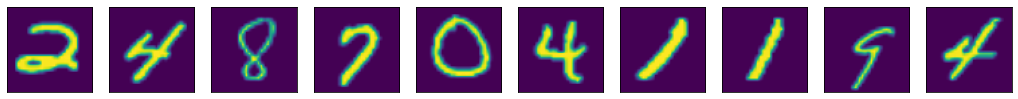

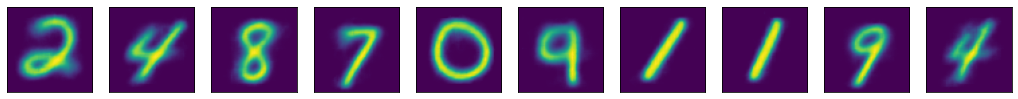

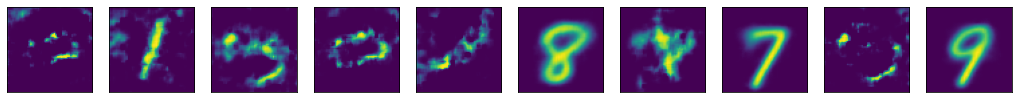

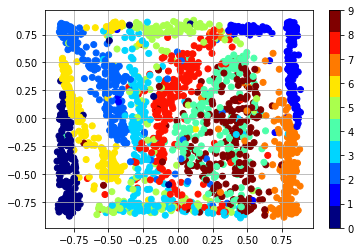

40001
lse_loss -1.3314459323883057
recon_loss 0.11306006833910942
40002
lse_loss -1.3312407970428466
recon_loss 0.10854111239314079
40003
lse_loss -1.3409283638000489
recon_loss 0.11535999551415443
40004
lse_loss -1.3368608474731445
recon_loss 0.11293377205729485
40005
lse_loss -1.3431840419769288
recon_loss 0.11723882630467415
40006
lse_loss -1.3361992835998535
recon_loss 0.1119052067399025
40007
lse_loss -1.331800889968872
recon_loss 0.11356186345219613
40008
lse_loss -1.33233323097229
recon_loss 0.11662076860666275
40009
lse_loss -1.3406168937683105
recon_loss 0.10967208817601204
40010
lse_loss -1.3365491390228272
recon_loss 0.11450122818350791
40011
lse_loss -1.3256382942199707
recon_loss 0.1135405384004116
40012
lse_loss -1.3385087490081786
recon_loss 0.10813343077898026
40013
lse_loss -1.3264108657836915
recon_loss 0.1201742485165596
40014
lse_loss -1.330682373046875
recon_loss 0.11467206329107285
40015
lse_loss -1.3395828247070312
recon_loss 0.11180609315633774
40016
lse_loss -1

lse_loss -1.3388727188110352
recon_loss 0.10736164748668671
40127
lse_loss -1.3304229259490967
recon_loss 0.11294658258557319
40128
lse_loss -1.3354785442352295
recon_loss 0.11320668533444404
40129
lse_loss -1.3402939796447755
recon_loss 0.12344352453947068
40130
lse_loss -1.3363098621368408
recon_loss 0.11289093792438507
40131
lse_loss -1.337614154815674
recon_loss 0.11393582224845886
40132
lse_loss -1.3280699729919434
recon_loss 0.1182161271572113
40133
lse_loss -1.3249177932739258
recon_loss 0.11731347143650055
40134
lse_loss -1.329031229019165
recon_loss 0.12182821407914161
40135
lse_loss -1.3264935970306397
recon_loss 0.1131229966878891
40136
lse_loss -1.333716917037964
recon_loss 0.11259331777691842
40137
lse_loss -1.3449527263641357
recon_loss 0.110043965280056
40138
lse_loss -1.3379799842834472
recon_loss 0.11293167695403099
40139
lse_loss -1.3265141487121581
recon_loss 0.10619230046868325
40140
lse_loss -1.3233914375305176
recon_loss 0.11580000817775726
40141
lse_loss -1.31688

lse_loss -1.3369686126708984
recon_loss 0.12010442167520523
40252
lse_loss -1.3340494632720947
recon_loss 0.11619939208030701
40253
lse_loss -1.3449292182922363
recon_loss 0.11398094594478607
40254
lse_loss -1.330802583694458
recon_loss 0.11498809456825257
40255
lse_loss -1.3376397132873534
recon_loss 0.11553501114249229
40256
lse_loss -1.3273046970367433
recon_loss 0.11048652306199074
40257
lse_loss -1.3260706901550292
recon_loss 0.11506077274680138
40258
lse_loss -1.3362547397613525
recon_loss 0.11717103347182274
40259
lse_loss -1.3397451877593993
recon_loss 0.11331243440508842
40260
lse_loss -1.3416022300720214
recon_loss 0.1128417395055294
40261
lse_loss -1.3364394664764405
recon_loss 0.1150892786681652
40262
lse_loss -1.3242208003997802
recon_loss 0.11086889952421189
40263
lse_loss -1.335004711151123
recon_loss 0.11720375791192054
40264
lse_loss -1.3325579643249512
recon_loss 0.11919666305184365
40265
lse_loss -1.3275692462921143
recon_loss 0.11477861851453781
40266
lse_loss -1.33

lse_loss -1.3344796657562257
recon_loss 0.11788374707102775
40377
lse_loss -1.3415729999542236
recon_loss 0.11194005906581879
40378
lse_loss -1.3275464534759522
recon_loss 0.11347571760416031
40379
lse_loss -1.3284302234649659
recon_loss 0.11182696893811225
40380
lse_loss -1.3323850631713867
recon_loss 0.11896298378705979
40381
lse_loss -1.327684497833252
recon_loss 0.11168209090828896
40382
lse_loss -1.3293232917785645
recon_loss 0.11382596641778946
40383
lse_loss -1.3292838096618653
recon_loss 0.1139398068189621
40384
lse_loss -1.3258491039276123
recon_loss 0.12241946756839753
40385
lse_loss -1.331270122528076
recon_loss 0.11206296309828759
40386
lse_loss -1.335860824584961
recon_loss 0.1180821567773819
40387
lse_loss -1.3357928276062012
recon_loss 0.11639137715101242
40388
lse_loss -1.3319183349609376
recon_loss 0.11536535024642944
40389
lse_loss -1.3370213985443116
recon_loss 0.1181828498840332
40390
lse_loss -1.3237446784973144
recon_loss 0.11196140423417092
40391
lse_loss -1.3204

lse_loss -1.330846118927002
recon_loss 0.11200234293937683
40502
lse_loss -1.3472989082336426
recon_loss 0.11387424021959305
40503
lse_loss -1.3349571228027344
recon_loss 0.11669472083449364
40504
lse_loss -1.3313827514648438
recon_loss 0.11711242720484734
40505
lse_loss -1.3354748725891112
recon_loss 0.11116415187716484
40506
lse_loss -1.3391544342041015
recon_loss 0.11827950850129128
40507
lse_loss -1.3441037654876709
recon_loss 0.11176655143499374
40508
lse_loss -1.3429881572723388
recon_loss 0.11147947907447815
40509
lse_loss -1.3386684894561767
recon_loss 0.11451313644647598
40510
lse_loss -1.3322023391723632
recon_loss 0.1148524135351181
40511
lse_loss -1.3212067127227782
recon_loss 0.10550382733345032
40512
lse_loss -1.3229548454284668
recon_loss 0.1191710114479065
40513
lse_loss -1.3213685035705567
recon_loss 0.11769967824220658
40514
lse_loss -1.339150619506836
recon_loss 0.11494454592466355
40515
lse_loss -1.3311376571655273
recon_loss 0.12031017243862152
40516
lse_loss -1.33

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        